In [87]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt


# Parameters
entry_threshold = 1.5
exit_threshold = 0.5
lookback_period = 252

# Stock tickers and date range
stock1_ticker = "AAPL"
stock2_ticker = "MSFT"
start_date = "2022-01-01"
end_date = "2023-06-29"
pair_trading_strategy(stock1_ticker, stock2_ticker, start_date, end_date, entry_threshold, exit_threshold, lookback_period)

def pair_trading_strategy(stock1_ticker, stock2_ticker, start_date, end_date, entry_threshold, exit_threshold, lookback_period):
    stock1_data = yf.download(stock1_ticker, start=start_date, end=end_date)
    stock2_data = yf.download(stock2_ticker, start=start_date, end=end_date)

    stock1_close = stock1_data['Close']
    stock2_close = stock2_data['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [64]:
    spread = stock1_close - stock2_close
    print(spread)


Date
2022-06-01   -649.299988
2022-06-02   -654.599987
2022-06-03   -640.849987
2022-06-06   -635.150013
2022-06-07   -628.549976
                 ...    
2023-06-06   -912.800011
2023-06-07   -921.250000
2023-06-08   -907.399975
2023-06-09   -921.400002
2023-06-12   -920.150013
Name: Close, Length: 256, dtype: float64


In [66]:
    z_score = (spread - np.mean(spread[-lookback_period:])) / np.std(spread[-lookback_period:])
    print(z_score)


Date
2022-06-01    1.545478
2022-06-02    1.483840
2022-06-03    1.643749
2022-06-06    1.710038
2022-06-07    1.786795
                ...   
2023-06-06   -1.518960
2023-06-07   -1.617231
2023-06-08   -1.456159
2023-06-09   -1.618976
2023-06-12   -1.604439
Name: Close, Length: 256, dtype: float64


In [67]:
    entry_signals = []
    exit_signals = []
    positions = []
    status = 'OUT'
    for i in z_score.index:
        if status == 'OUT' and z_score[i] > entry_threshold:
            entry_signals.append(i)
            positions.append('LONG')
            status = 'IN'
        elif status == 'OUT' and z_score[i] < -entry_threshold:
            entry_signals.append(i)
            positions.append('SHORT')
            status = 'IN'
        elif status == 'IN' and z_score[i] < exit_threshold:
            exit_signals.append(i)
            positions.append('EXIT')
            status = 'OUT'
        elif status == 'IN' and z_score[i] > -exit_threshold:
            exit_signals.append(i)
            positions.append('EXIT')
            status = 'OUT'
        else:
            positions.append(np.nan)


In [69]:
    # Calculate correlation matrix
    returns = pd.concat([stock1_close, stock2_close], axis=1).pct_change().dropna()
    correlation_matrix = returns.corr()
    print(correlation_matrix)



         Close    Close
Close  1.00000  0.24931
Close  0.24931  1.00000


In [70]:
    # Select the pair of stocks with the highest correlation
    pair = correlation_matrix.unstack().sort_values(ascending=False).drop_duplicates()
    stock1_ticker, stock2_ticker = pair.index[0]


    # Calculate the spread between the prices of the selected stocks
    selected_spread = stock1_close - stock2_close
    print(selected_spread)



Date
2022-06-01   -649.299988
2022-06-02   -654.599987
2022-06-03   -640.849987
2022-06-06   -635.150013
2022-06-07   -628.549976
                 ...    
2023-06-06   -912.800011
2023-06-07   -921.250000
2023-06-08   -907.399975
2023-06-09   -921.400002
2023-06-12   -920.150013
Name: Close, Length: 256, dtype: float64


In [72]:
    # Generate entry and exit signals for the selected stocks
    selected_entry_signals, selected_exit_signals = generate_signals(selected_spread, entry_threshold, exit_threshold)


    # Backtest the pair trading strategy
    cumulative_returns, sharpe_ratio, max_drawdown = backtest_pair_trading(stock1_close, stock2_close, selected_entry_signals, selected_exit_signals)

    # Print the results
    print("Stock Pair: {} and {}".format(stock1_ticker, stock2_ticker))
    print("Cumulative Returns: {:.2f}".format(cumulative_returns[-1]))
    print("Sharpe Ratio: {:.2f}".format(sharpe_ratio))
    print("Maximum Drawdown: {:.2f}".format(max_drawdown))




Stock Pair: Close and Close
Cumulative Returns: 0.94
Sharpe Ratio: -0.28
Maximum Drawdown: -0.25


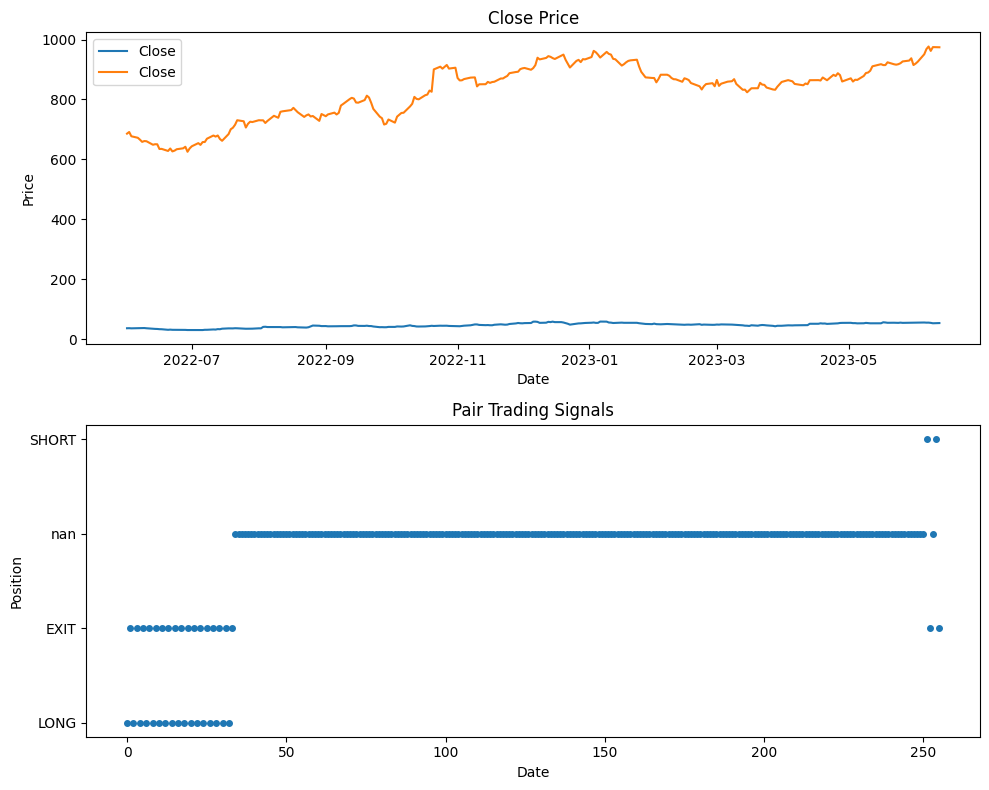

In [73]:
    # Plot close price and pair trading signals for stock1 and stock2
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))
    axs[0].plot(stock1_close, label=stock1_ticker)
    axs[0].plot(stock2_close, label=stock2_ticker)
    axs[0].set_title("Close Price")
    axs[0].set_xlabel("Date")
    axs[0].set_ylabel("Price")
    axs[0].legend()

    axs[1].plot(positions, marker='o', linestyle='', markersize=4)
    axs[1].set_title("Pair Trading Signals")
    axs[1].set_xlabel("Date")
    axs[1].set_ylabel("Position")

    plt.tight_layout()
    plt.show()


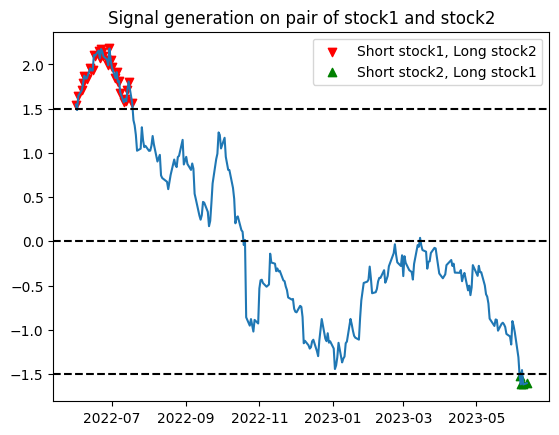

In [79]:
# Generate entry and exit signals based on the z-score thresholds
sell_signals = z_score[z_score > entry_threshold].index
buy_signals = z_score[z_score < -entry_threshold].index

plt.figure()
plt.title("Signal generation on pair of stock1 and stock2")
plt.plot(z_score.index, z_score)
plt.scatter(sell_signals, z_score[sell_signals], marker='v', color='r', label='Short stock1, Long stock2')
plt.scatter(buy_signals, z_score[buy_signals], marker='^', color='g', label='Short stock2, Long stock1')
plt.axhline(entry_threshold, linestyle='dashed', color='black')
plt.axhline(-entry_threshold, linestyle='dashed', color='black')
plt.axhline(0, linestyle='dashed', color='black')
plt.legend()


In [94]:
def pair_trading_strategy1(stock1_ticker, stock2_ticker, start_date, end_date, entry_threshold, exit_threshold, lookback_period):
    # Download historical price data for the stocks
    stock1_data = yf.download(stock1_ticker, start=start_date, end=end_date)['Close']
    stock2_data = yf.download(stock2_ticker, start=start_date, end=end_date)['Close']

    # Calculate the spread between the prices of the two stocks
    spread = stock1_data - stock2_data

    # Calculate the z-score of the spread
    z_score = (spread - np.mean(spread[-lookback_period:])) / np.std(spread[-lookback_period:])

    # Generate entry and exit signals based on the z-score thresholds
    entry_signals = z_score > entry_threshold
    exit_signals = z_score < -entry_threshold


# Calculate the spread between the prices of the two selected stocks
def calculate_spread(stock1_data, stock2_data):
    spread = stock1_data - stock2_data
    return spread

# Develop entry and exit rules for the pair trading strategy
def generate_signals(spread, entry_threshold, exit_threshold):
    z_score = (spread - np.mean(spread)) / np.std(spread)
    entry_signal = z_score > entry_threshold
    exit_signal = z_score < -entry_threshold
    return entry_signal, exit_signal

# Backtest the pair trading strategy
def backtest_pair_trading(stock1_data, stock2_data, entry_signal, exit_signal):
    spread = calculate_spread(stock1_data, stock2_data)

    positions = np.zeros(len(spread))
    positions[entry_signal] = -1  # Short stock1 and long stock2
    positions[exit_signal] = 0  # Exit positions
    positions = pd.Series(positions, index=spread.index)

    # Calculate daily returns
    stock1_returns = stock1_data.pct_change()
    stock2_returns = stock2_data.pct_change()
    strategy_returns = stock1_returns * positions.shift(1) + stock2_returns * positions.shift(1)

    # Calculate cumulative returns
    cumulative_returns = (1 + strategy_returns).cumprod()

    # Calculate Sharpe ratio
    daily_returns = strategy_returns.dropna()
    sharpe_ratio = np.sqrt(252) * (np.mean(daily_returns) / np.std(daily_returns))

    # Calculate maximum drawdown
    rolling_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - rolling_max) / rolling_max
    max_drawdown = np.min(drawdown)

    return cumulative_returns, sharpe_ratio, max_drawdown


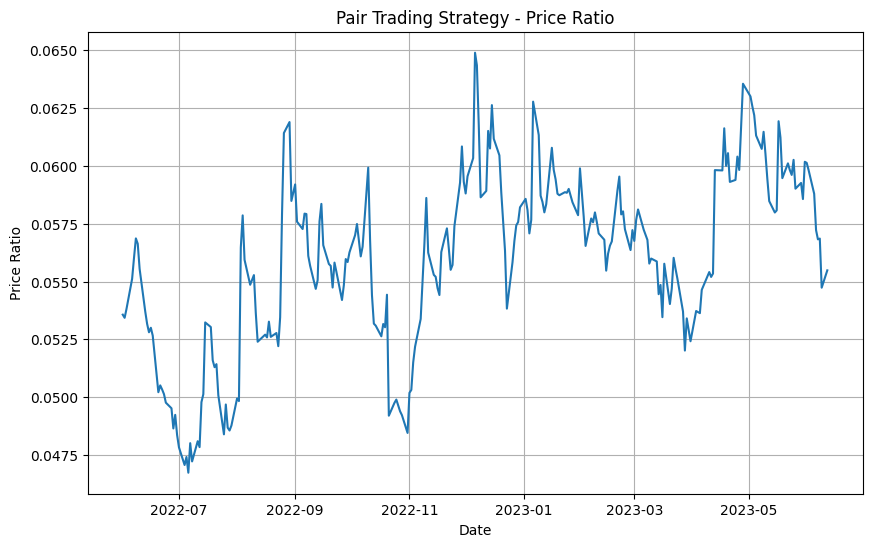

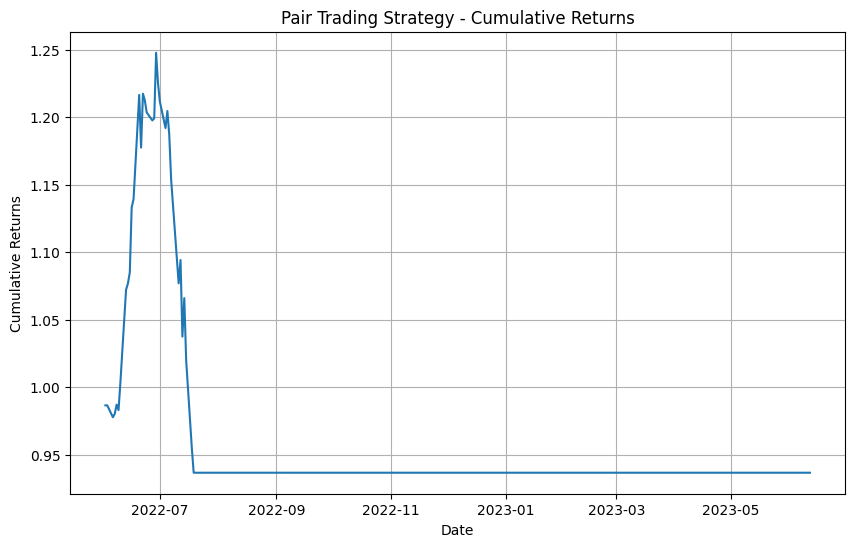

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [100]:

    # Plot price ratio
    plt.figure(figsize=(10, 6))
    plt.plot(price_ratio)
    plt.title("Pair Trading Strategy - Price Ratio")
    plt.xlabel("Date")
    plt.ylabel("Price Ratio")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_returns)
    plt.title("Pair Trading Strategy - Cumulative Returns")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Returns")
    plt.grid(True)
    plt.show()

entry_threshold = 1.5
exit_threshold = 0.5
lookback_period = 252

stock1_ticker = "AAPL"
stock2_ticker = "MSFT"
start_date = "2022-01-01"
end_date = "2023-06-29"
pair_trading_strategy1(stock1_ticker, stock2_ticker, start_date, end_date, entry_threshold, exit_threshold, lookback_period)
